In [223]:
import csv
from pathlib import Path
import os
#from numpy import genfromtxt
from matplotlib import pyplot as plt
import numpy as np
import torch
import gpytorch
# import glob
# from Plotting_functions.Plotting_functions import Plot_filtered_signal, Plot_long_term_predictions, print_model_parameters, \
#                                                   produce_long_term_predictions, filter_train_and_test_data
#                                                   # rebuild_kernel_analytically_zero_mean_RBF,

# from GP_MPCC_generate_solvers.functions_for_GP_solver_generation import produce_K_xy_Zero_mean_RBF

# Added by Riccardo
import glob
from tqdm.notebook import tqdm
import os
from numpy import genfromtxt
import time
import scipy
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader

import casadi

In [224]:
def nominal_dynamics( throttle, delta_cmd, v_x, v_y, w):
    
    L = 0.175
    m = 1.63
    Iz = 0.0061
    lr = 0.45*L
    lf = L - lr
    dt = 0.1
    
    # Joystick
#     coeff = np.array([ 0.693269796073301,1.95806694464934,1.92085952988382,0.686447602670706,0.769561720505785,1.05964496201507,33.6975812374592,1.09360535677470,4.30726112026115])
    
    # LOW SPEED 
#     coeff = np.array([0.464057573497732, 3.456346397163573, 19.451653912004943, 0.173236915980059, 0.079416030663782,1.328088550698735, 4.890646929001010, 1.091612670338737, 9.940588122706625*10**(-8)])
    
    # HIGH SPEED
#     coeff = np.array([0.679115033132576, 1.193406751450747, 1.207698614596029, 5.811380339145567, 1.383597852169577, 0.263095423084969, 6.918962475385593, 1.241782612109949, 5.697407191996113*10**(-4)])

    # MEDIUM SPEED long batch
    coeff = np.array([55.619546090802665,2.455122820164469,0.010656085085740,10.390787245737815,2.372514246591150,0.050831207731079,11.244777487512259,1.821951728405532,6.889277937871838*10**(-4)])
    
    
    Df = coeff[0]
    Dr = coeff[1]
    Cf = coeff[2]
    Cr = coeff[3]
    Bf = coeff[4]
    Br = coeff[5]
        
    a_mot = coeff[6]
    b_mot = coeff[7]
    c_mot = coeff[8]

#     delta = 0.3389*np.arctan2(1.461*delta_cmd,1)
    delta = delta_cmd
    
    alpha_f = delta - np.arctan2( v_y + lf*w, v_x )
    alpha_r = np.arctan2( -v_y + lr*w, v_x )
    
    Fx = ( a_mot*throttle - b_mot*v_x - c_mot ) * m
    Ff = Df*np.sin(Cf*np.arctan2(Bf*alpha_f,1))
    Fr = Dr*np.sin(Cr*np.arctan2(Br*alpha_r,1))
        
    acc_x = 1/m * ( Fx/2 + Fx/2*np.cos(delta) - Ff*np.sin(delta) + m*v_y*w )

    acc_y = 1/m * ( Fx/2*np.sin(delta) + Fr + Ff*np.cos(delta) - m*v_x*w )
    
    w_dot = 1/Iz * ( lf * ( Fx/2*np.sin(delta) + Ff*np.cos(delta) ) - Fr*lr)
    
    v_x_next = v_x + dt * acc_x
    v_y_next = v_y + dt * acc_y
    w_next = w + dt * w_dot
    
    f_nom = torch.tensor([ [ v_x_next, v_y_next, w_next ] ])
    
    return f_nom

In [225]:
def produce_K_xy_Zero_mean_RBF(x, y, outputscale, lengthscales):

    length_mat = np.diag(lengthscales)
    lengths_pow_minus_2 = np.linalg.inv(np.matmul(length_mat, length_mat))

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    size_x = len(x[:, 0])
    size_y = len(y[:, 0])
    Kxy = np.zeros([size_x, size_y])


    for i in range(size_x):
        xi = x[i, :]
        for j in range(size_y):
            xj = y[j, :]
            Kxy[i, j] = outputscale * np.exp(-0.5 * (np.matmul(np.matmul(np.transpose(xi - xj), lengths_pow_minus_2), xi - xj)))

    return Kxy

def produce_K_xstar_X_Zero_mean_RBF_4casadi(x_star, x_data, outputscale, lengthscales):

    n_data = x_data.shape[0]  # cause really we will use this with only 1 data point where to evaluate the GP
    m_features = x_data.shape[1]


    lengths_pow_minus_2 = casadi.SX.zeros(m_features, 1)
    for i in range(m_features):
        lengths_pow_minus_2[i] = 1 / (lengthscales[i] * lengthscales[i])

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    #hard coded features and data points

    #Kxy = np.zeros([size_x, size_y])
    K_xstar_X = casadi.SX.zeros(1, n_data)

    # re-writing to avoid any over-writing of variables
    """
        for j in range(n_data):
            xj = x_data[j, :]
            #this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
            exp_arg = casadi.SX.zeros(1, 1)
            for k in range(m_features):
                exp_arg = exp_arg + (x_star[k]-xj[k]) * (x_star[k]-xj[k]) * lengths_pow_minus_2[k]
    
            K_xstar_X[j] = outputscale * casadi.exp(-0.5 * exp_arg)
    """
    for j in range(n_data):
        xj = x_data[j, :]
        # this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
        #exp_arg = casadi.SX.zeros(1, m_features)
        #for k in range(m_features):
        #    exp_arg[k] = ((x_star[k] - xj[k]) * (x_star[k] - xj[k]) * lengths_pow_minus_2[k])
        # this is really really hard coded to avoid any chance of weird behaviour
        K_xstar_X[j] = outputscale * casadi.exp(-0.5 * (((x_star[0] - xj[0]) * (x_star[0] - xj[0]) * lengths_pow_minus_2[0])+
                                                        ((x_star[1] - xj[1]) * (x_star[1] - xj[1]) * lengths_pow_minus_2[1])+
                                                        ((x_star[2] - xj[2]) * (x_star[2] - xj[2]) * lengths_pow_minus_2[2])+
                                                        ((x_star[3] - xj[3]) * (x_star[3] - xj[3]) * lengths_pow_minus_2[3])+
                                                        ((x_star[4] - xj[4]) * (x_star[4] - xj[4]) * lengths_pow_minus_2[4])))


    return K_xstar_X



def produce_K_xstar_X_Zero_mean_RBF(x_star, x_data, outputscale, lengthscales):

    n_data = x_data.shape[0]  # cause really we will use this with only 1 data point where to evaluate the GP
    m_features = x_data.shape[1]


    lengths_pow_minus_2 = np.zeros(m_features)
    for i in range(m_features):
        lengths_pow_minus_2[i] = 1 / (lengthscales[i] * lengthscales[i])

    # it will come out like [nx ny] where x = [nx, M] y = [ny, M], M features
    #hard coded features and data points

    #Kxy = np.zeros([size_x, size_y])
    K_xstar_X = np.zeros(n_data)

    # re-writing to avoid any over-writing of variables
    """
        for j in range(n_data):
            xj = x_data[j, :]
            #this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
            exp_arg = casadi.SX.zeros(1, 1)
            for k in range(m_features):
                exp_arg = exp_arg + (x_star[k]-xj[k]) * (x_star[k]-xj[k]) * lengths_pow_minus_2[k]
    
            K_xstar_X[j] = outputscale * casadi.exp(-0.5 * exp_arg)
    """
    for j in range(n_data):
        xj = x_data[j, :]
        # this for loop is only to avoid matrix multiplication in casadi (maybe it's not necessary)
        #exp_arg = casadi.SX.zeros(1, m_features)
        #for k in range(m_features):
        #    exp_arg[k] = ((x_star[k] - xj[k]) * (x_star[k] - xj[k]) * lengths_pow_minus_2[k])
        # this is really really hard coded to avoid any chance of weird behaviour
        K_xstar_X[j] = outputscale * np.exp(-0.5 * (((x_star[0] - xj[0]) * (x_star[0] - xj[0]) * lengths_pow_minus_2[0])+
                                                        ((x_star[1] - xj[1]) * (x_star[1] - xj[1]) * lengths_pow_minus_2[1])+
                                                        ((x_star[2] - xj[2]) * (x_star[2] - xj[2]) * lengths_pow_minus_2[2])+
                                                        ((x_star[3] - xj[3]) * (x_star[3] - xj[3]) * lengths_pow_minus_2[3])+
                                                        ((x_star[4] - xj[4]) * (x_star[4] - xj[4]) * lengths_pow_minus_2[4])))


    return K_xstar_X


In [226]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_points.shape[-1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=inducing_points.shape[-1]))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [227]:
# load data and models dictionaries

path_to_Data = '/home/riccardo/THESIS_CODE/Saved_models_and_data_sim_Riccardo_NO_DELTA/'

train_x = torch.load(path_to_Data + 'train_x.pt')
train_y_Delta_vx = torch.load(path_to_Data + 'train_y_Delta_vx.pt')
train_y_Delta_vy = torch.load(path_to_Data + 'train_y_Delta_vy.pt')
train_y_Delta_w = torch.load(path_to_Data + 'train_y_Delta_w.pt')
test_x = torch.load(path_to_Data + 'test_x.pt')
X_test = torch.load(path_to_Data + 'X_test.pt')
Y_test = torch.load(path_to_Data + 'Y_test.pt')
tau_test = torch.load(path_to_Data + 'tau_test.pt')
steer_test = torch.load(path_to_Data + 'steer_test.pt')
theta_test = torch.load(path_to_Data + 'theta_test.pt')
state_dict_Delta_vx = torch.load(path_to_Data + 'model_Delta_vx.pth')
state_dict_Delta_vy = torch.load(path_to_Data + 'model_Delta_vy.pth')
state_dict_Delta_w = torch.load(path_to_Data + 'model_Delta_w.pth')
noise = torch.load( path_to_Data + 'noise.pt')

print(noise)
noise_Delta_vx = noise[0]
noise_Delta_vy = noise[1]
noise_Delta_w = noise[2]

train_x.shape

[0.0005177396815270185, 0.0001901044452097267, 0.03938058018684387]


torch.Size([1558, 5])

In [228]:
# inducing_points = train_x[::int(train_x.shape[-2]/200),:]
inducing_points = train_x[:50,:]
print(inducing_points.shape)

torch.Size([50, 5])


In [229]:
likelihood_Delta_vx = gpytorch.likelihoods.GaussianLikelihood()
model_Delta_vx = GPModel(inducing_points=inducing_points)
model_Delta_vx.load_state_dict(state_dict_Delta_vx)

<All keys matched successfully>

In [230]:
likelihood_Delta_vy = gpytorch.likelihoods.GaussianLikelihood()
model_Delta_vy = GPModel(inducing_points=inducing_points)
model_Delta_vy.load_state_dict(state_dict_Delta_vy)

<All keys matched successfully>

In [231]:
likelihood_Delta_w = gpytorch.likelihoods.GaussianLikelihood()
model_Delta_w = GPModel(inducing_points=inducing_points)
model_Delta_w.load_state_dict(state_dict_Delta_w)
# print(state_dict_vx)

<All keys matched successfully>

In [232]:
# model_Delta_vx = model_Delta_vx.double()
# model_vy = model_vy.double()
# model_omega = model_omega.double()

model_Delta_vx.eval()
likelihood_Delta_vx.eval()

model_Delta_vy.eval()
likelihood_Delta_vy.eval()

model_Delta_w.eval()
likelihood_Delta_w.eval()

# pred_vx_test = likelihood_vx(model_vx(test_x))
# print(pred_vx_test.mean)
# plt.figure(figsize=(18,8))
# plt.plot(pred_vx_test.mean.detach().numpy())
# pred_vy_train = likelihood_vy(model_vy(train_x))
# pred_w_train = likelihood_omega(model_omega(train_x))

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [233]:
#k_rebuilt = rebuild_kernel_analytically_zero_mean_RBF(outputscale_w, lengthscales_w)

#build k(X,X)-1 * Y  matrix
n_train_datapoints = train_x.size()[0]
m_features = train_x.size()[1]
print('')
print('n data points', n_train_datapoints)
print('m_features', m_features)
print('')

x_detached = train_x.cpu().detach().numpy()
#transform x_detached into a vector since forces can only receive parameters
x_data_vec = []
for i in range(n_train_datapoints):
    x_data_vec = [*x_data_vec, *x_detached[i]]

print(len(x_data_vec))

# np.save( path_to_Data + 'forces_params_X_data.npy', x_data_vec)
# x_data_vec_loaded = np.load( path_to_Data +'forces_params_X_data.npy')


n data points 1558
m_features 5

7790


In [234]:
# likelihood_Delta_vx(train_x)
outputscale_Delta_vx = model_Delta_vx.covar_module.outputscale.cpu().detach().numpy()
lengthscales_Delta_vx = model_Delta_vx.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]
lengthscales_Delta_vx[0] = 1000
u_vx = state_dict_Delta_vx['variational_strategy.inducing_points']

u_vx_detached = u_vx.cpu().detach().numpy()

#transform x_detached into a vector since forces can only receive parameters

u_vx_data_vec = []
for i in range(u_vx.size()[0]):
    u_vx_data_vec = [*u_vx_data_vec, *u_vx_detached[i]]


print('outputscale', outputscale_Delta_vx)
print('lengthscales', lengthscales_Delta_vx)
print('noise', noise_Delta_vx)


# np.save( path_to_Data + 'forces_params_X_data.npy', u_vx_data_vec)
# u_vx_data_vec_loaded = np.load( path_to_Data +'forces_params_X_data.npy')

print(u_vx_detached.shape)

outputscale 0.13923688
lengthscales [1000.           4.0905004    1.5739408    2.3919377    3.4490607]
noise 0.0005177396815270185
(50, 5)


In [235]:
# mu = K_xu * sigma * K_uf * inv_lambda * tran_y

# inv_lambda = (sigma_noise*I)^-1

# sigma = (K_uu + K_uf*inv_lambda*K_uf) ^-1

# rhs = sigma * K_uf * inv_lambda * tran_y

K_uu_vx = produce_K_xy_Zero_mean_RBF(u_vx_detached, u_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
noise_mat_vx =  (noise_Delta_vx) * np.identity(n_train_datapoints)
inv_lambda_vx = np.linalg.inv(noise_mat_vx)
K_uf_vx = produce_K_xy_Zero_mean_RBF(u_vx_detached, train_x.detach().numpy(), outputscale_Delta_vx, lengthscales_Delta_vx)
sigma_vx = np.linalg.inv(K_uu_vx + np.matmul(K_uf_vx, np.matmul(inv_lambda_vx, np.transpose(K_uf_vx)) ) )

rhs_vx = np.matmul(inv_lambda_vx, train_y_Delta_vx)
inner_vx = np.matmul(sigma_vx, K_uf_vx) 

right_vec_block_Delta_vx = np.matmul(inner_vx, rhs_vx)

K_xu = produce_K_xstar_X_Zero_mean_RBF(test_x[1,:].detach().numpy(), u_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)

exp = np.matmul(K_xu, right_vec_block_Delta_vx)
print(exp)


tensor(0.0108, dtype=torch.float64)


In [236]:
# K_zz_mat_Delta_vx = produce_K_xy_Zero_mean_RBF(z_vx_detached, z_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# print(K_zz_mat_Delta_vx)

# noise_Delta_vx_mat = noise_Delta_vx * np.identity(n_train_datapoints)
# print(noise_Delta_vx_mat.shape)


# K_Xz_mat_Delta_vx = produce_K_xy_Zero_mean_RBF(x_detached, z_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# print(K_Xz_mat_Delta_vx.shape)

# K_zX_mat_Delta_vx = produce_K_xy_Zero_mean_RBF(z_vx_detached, x_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# print(K_zX_mat_Delta_vx.shape)

# K_XX_mat_Delta_vx = np.matmul(K_Xz_mat_Delta_vx, np.matmul(K_zz_mat_Delta_vx, K_zX_mat_Delta_vx))
# print(K_XX_mat_Delta_vx.shape)

# K_XX_mat_Delta_vx_inv_noise_Delta_vx = np.linalg.inv(K_XX_mat_Delta_vx + noise_Delta_vx_mat)
# print(K_XX_mat_Delta_vx_inv_noise_Delta_vx)

# right_vec_block_Delta_vx = np.matmul(K_XX_mat_Delta_vx_inv_noise_Delta_vx, train_y_Delta_vx.cpu().detach().numpy())


##########################################################################################################

# K_zz_mat_Delta_vx = produce_K_xy_Zero_mean_RBF(z_vx_detached, z_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# print(K_zz_mat_Delta_vx)
# L = np.linalg.cholesky(K_zz_mat_Delta_vx)

# # noise_Delta_vx = 0.087
# noise_Delta_vx_mat = noise_Delta_vx * np.identity(z_vx.shape[0])

# K_zz_mat_Delta_vx_inv_noise_Delta_vx = np.linalg.inv(K_zz_mat_Delta_vx + noise_Delta_vx_mat)

# right_vec_block_Delta_vx = np.matmul(K_zz_mat_Delta_vx_inv_noise_Delta_vx, u_vx.cpu().detach().numpy())

# print(right_vec_block_Delta_vx.shape)

# point_test = test_x[0,:].detach().numpy()

# print(point_test)

# K_xz = produce_K_xstar_X_Zero_mean_RBF(point_test, z_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# # K_xz_cas = produce_K_xstar_X_Zero_mean_RBF_4casadi(point_test, z_vx_detached, outputscale_Delta_vx, lengthscales_Delta_vx)
# print(K_xz.shape)
# # print(K_xz_cas)

# out = np.matmul(K_xz, right_vec_block_Delta_vx)

# print(out)

# # save right block matrix as a list of parameters for forces
# file_forces_params_Delta_vx_model_params = path_to_Data + 'forces_params_Delta_vx_model_params.npy'
# file_forces_params_Delta_vx_right_vec = path_to_Data + 'file_forces_params_Delta_vx_right_vec.npy'
# np.save(file_forces_params_Delta_vx_model_params, [outputscale_Delta_vx, *lengthscales_Delta_vx])
# np.save(file_forces_params_Delta_vx_right_vec, right_vec_block_Delta_vx)


In [237]:
# likelihood_Delta_vy(train_y)
outputscale_Delta_vy = model_Delta_vy.covar_module.outputscale.cpu().detach().numpy()
lengthscales_Delta_vy = model_Delta_vy.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]
u_vy = state_dict_Delta_vy['variational_strategy.inducing_points']

u_vy_detached = u_vy.cpu().detach().numpy()

#transform x_detached into a vector since forces can only receive parameters

u_vy_data_vec = []
for i in range(u_vy.size()[0]):
    u_vy_data_vec = [*u_vy_data_vec, *u_vy_detached[i]]

print('outputscale', outputscale_Delta_vy)
print('lengthscales', lengthscales_Delta_vy)
print('noise', noise_Delta_vy)

# np.save( path_to_Data + 'forces_params_X_data.npy', u_vy_data_vec)
# u_vy_data_vec_loaded = np.load( path_to_Data +'forces_params_X_data.npy')

outputscale 0.028387494
lengthscales [4.412473  4.7628627 3.7945504 0.8420636 5.9591975]
noise 0.0001901044452097267


In [238]:
# mu = K_xu * sigma * K_uf * inv_lambda * tran_y

# inv_lambda = (sigma_noise*I)^-1

# sigma = (K_uu + K_uf*inv_lambda*K_uf) ^-1

# rhs = sigma * K_uf * inv_lambda * tran_y

K_uu_vy = produce_K_xy_Zero_mean_RBF(u_vy_detached, u_vy_detached, outputscale_Delta_vy, lengthscales_Delta_vy)
noise_mat_vy =  noise_Delta_vy * np.identity(n_train_datapoints)
inv_lambda_vy = np.linalg.inv(noise_mat_vy)
K_uf_vy = produce_K_xy_Zero_mean_RBF(u_vy_detached, train_x.detach().numpy(), outputscale_Delta_vy, lengthscales_Delta_vy)
sigma_vy = np.linalg.inv(K_uu_vy + np.matmul(K_uf_vy, np.matmul(inv_lambda_vy, np.transpose(K_uf_vy)) ) )

rhs_vy = np.matmul(inv_lambda_vy, train_y_Delta_vy)
inner_vy = np.matmul(sigma_vy, K_uf_vy) 

right_vec_block_Delta_vy = np.matmul(inner_vy, rhs_vy)

K_xu = produce_K_xstar_X_Zero_mean_RBF(test_x[0,:].detach().numpy(), u_vy_detached, outputscale_Delta_vy, lengthscales_Delta_vy)

exp = np.matmul(K_xu, right_vec_block_Delta_vy)
print(exp)

tensor(0.0004, dtype=torch.float64)


In [239]:
# K_XX_mat_Delta_vy = produce_K_xy_Zero_mean_RBF(x_detached, x_detached, outputscale_Delta_vy, lengthscales_Delta_vy)
# # so an MPC would get this stuff as parameters
# noise_Delta_vy_mat = noise_Delta_vy * np.identity(n_train_datapoints)
# K_XX_mat_Delta_vy_inv_noise_Delta_vy = np.linalg.inv(K_XX_mat_Delta_vy + noise_Delta_vy_mat)
# right_vec_block_Delta_vy = np.matmul(K_XX_mat_Delta_vy_inv_noise_Delta_vy, train_y_Delta_vy.cpu().detach().numpy())
# # save right block matrix as a list of parameters for forces
# file_forces_params_Delta_vy_model_params = path_to_Data + 'forces_params_Delta_vy_model_params.npy'
# file_forces_params_Delta_vy_right_vec = path_to_Data + 'file_forces_params_Delta_vy_right_vec.npy'
# np.save(file_forces_params_Delta_vy_model_params, [outputscale_Delta_vy, *lengthscales_Delta_vy])
# np.save(file_forces_params_Delta_vy_right_vec, right_vec_block_Delta_vy)

In [240]:
# likelihood_Delta_w(train_w)
outputscale_Delta_w = model_Delta_w.covar_module.outputscale.cpu().detach().numpy()
lengthscales_Delta_w = model_Delta_w.covar_module.base_kernel.lengthscale.cpu().detach().numpy()[0]
u_w = state_dict_Delta_w['variational_strategy.inducing_points']

u_w_detached = u_w.cpu().detach().numpy()

#transform x_detached into a vector since forces can only receive parameters

u_w_data_vec = []
for i in range(u_w.size()[0]):
    u_w_data_vec = [*u_w_data_vec, *u_w_detached[i]]

print('outputscale', outputscale_Delta_w)
print('lengthscales', lengthscales_Delta_w)
print('noise', noise_Delta_w)

# np.save( path_to_Data + 'forces_params_X_data.npy', u_w_data_vec)
# u_w_data_vec_loaded = np.load( path_to_Data +'forces_params_X_data.npy')

outputscale 0.31334275
lengthscales [1.8974011  0.91955686 1.4454248  1.8530006  1.4795219 ]
noise 0.03938058018684387


In [241]:
# mu = K_xu * sigma * K_uf * inv_lambda * tran_y

# inv_lambda = (sigma_noise*I)^-1

# sigma = (K_uu + K_uf*inv_lambda*K_uf) ^-1

# rhs = sigma * K_uf * inv_lambda * tran_y

K_uu_w = produce_K_xy_Zero_mean_RBF(u_w_detached, u_w_detached, outputscale_Delta_w, lengthscales_Delta_w)
noise_mat_w =  noise_Delta_w * np.identity(n_train_datapoints)
inv_lambda_w = np.linalg.inv(noise_mat_w)
K_uf_w = produce_K_xy_Zero_mean_RBF(u_w_detached, train_x.detach().numpy(), outputscale_Delta_w, lengthscales_Delta_w)
sigma_w = np.linalg.inv(K_uu_w + np.matmul(K_uf_w, np.matmul(inv_lambda_w, np.transpose(K_uf_w)) ) )

rhs_w = np.matmul(inv_lambda_w, train_y_Delta_w)
inner_w = np.matmul(sigma_w, K_uf_w) 

right_vec_block_Delta_w = np.matmul(inner_w, rhs_w)

K_xu = produce_K_xstar_X_Zero_mean_RBF(test_x[2,:].detach().numpy(), u_w_detached, outputscale_Delta_w, lengthscales_Delta_w)

exp = np.matmul(K_xu, right_vec_block_Delta_w)
print(exp)



tensor(0.0086, dtype=torch.float64)


In [242]:
u_ext = u_vx_data_vec + u_vy_data_vec + u_w_data_vec 
len(u_ext)

750

In [243]:
right_vec_block_Delta_vy.shape

torch.Size([50])

In [244]:
np.save( path_to_Data + 'forces_params_X_data.npy', u_ext)
u_ext_loaded = np.load( path_to_Data +'forces_params_X_data.npy')

# save right block matrix as a list of parameters for forces
file_forces_params_Delta_vx_model_params = path_to_Data + 'forces_params_Delta_vx_model_params.npy'
file_forces_params_Delta_vx_right_vec = path_to_Data + 'file_forces_params_Delta_vx_right_vec.npy'
np.save(file_forces_params_Delta_vx_model_params, [outputscale_Delta_vx, *lengthscales_Delta_vx])
np.save(file_forces_params_Delta_vx_right_vec, right_vec_block_Delta_vx)

# save right block matrix as a list of parameters for forces
file_forces_params_Delta_vy_model_params = path_to_Data + 'forces_params_Delta_vy_model_params.npy'
file_forces_params_Delta_vy_right_vec = path_to_Data + 'file_forces_params_Delta_vy_right_vec.npy'
np.save(file_forces_params_Delta_vy_model_params, [outputscale_Delta_vy, *lengthscales_Delta_vy])
np.save(file_forces_params_Delta_vy_right_vec, right_vec_block_Delta_vy)

# save right block matrix as a list of parameters for forces
file_forces_params_Delta_w_model_params = path_to_Data + 'forces_params_Delta_w_model_params.npy'
file_forces_params_Delta_w_right_vec = path_to_Data + 'file_forces_params_Delta_w_right_vec.npy'
np.save(file_forces_params_Delta_w_model_params, [outputscale_Delta_w, *lengthscales_Delta_w])
np.save(file_forces_params_Delta_w_right_vec, right_vec_block_Delta_w)

In [245]:
outputscale_Delta_vx

array(0.13923688, dtype=float32)

In [246]:
train_x_4_mat = train_x.cpu().detach().numpy()
train_y_vx_4_mat = train_y_Delta_vx.cpu().detach().numpy()
train_y_vy_4_mat = train_y_Delta_vy.cpu().detach().numpy()
train_y_w_4_mat = train_y_Delta_w.cpu().detach().numpy()

u_vx_4_mat = u_vx.cpu().detach().numpy()
u_vy_4_mat = u_vy.cpu().detach().numpy()
u_w_4_mat = u_w.cpu().detach().numpy()

right_vec_block_Delta_vx_4_mat = right_vec_block_Delta_vx.cpu().detach().numpy()
right_vec_block_Delta_vy_4_mat = right_vec_block_Delta_vy.cpu().detach().numpy()
right_vec_block_Delta_w_4_mat = right_vec_block_Delta_w.cpu().detach().numpy()

mdic1 = {'train_x': train_x_4_mat}
mdic2 = {'train_y_vx': train_y_vx_4_mat}
mdic3 = {'train_y_vy': train_y_vy_4_mat}
mdic4 = {'train_y_w': train_y_w_4_mat}
mdic5 = {'u_vx': u_vx_4_mat}
mdic6 = {'u_vy': u_vy_4_mat}
mdic7 = {'u_w': u_w_4_mat}
mdic8 = {'right_vec_block_Delta_vx': right_vec_block_Delta_vx_4_mat}
mdic9 = {'right_vec_block_Delta_vy': right_vec_block_Delta_vy_4_mat}
mdic10 = {'right_vec_block_Delta_w': right_vec_block_Delta_w_4_mat}

mdic11 = {'lengthscale_vx': lengthscales_Delta_vx}
mdic12 = {'lengthscale_vy': lengthscales_Delta_vy}
mdic13 = {'lengthscake_w': lengthscales_Delta_w}

mdic14 = {'outputscale_vx': outputscale_Delta_vx}
mdic15 = {'outputscale_vy': outputscale_Delta_vy}
mdic16 = {'outputscale_w': outputscale_Delta_w}

In [247]:
matlab_path = '/home/riccardo/Riccardo_Jetracer_WS_github/Codice-Riccardo/MatLab_data/'

scipy.io.savemat( matlab_path + 'train_x.mat', mdic1)
scipy.io.savemat(  matlab_path + 'train_y_vx.mat', mdic2)
scipy.io.savemat( matlab_path + 'train_y_vy.mat', mdic3)
scipy.io.savemat( matlab_path + 'train_y_w.mat', mdic4)

scipy.io.savemat( matlab_path + 'u_vx.mat', mdic5)
scipy.io.savemat( matlab_path + 'u_vy.mat', mdic6)
scipy.io.savemat( matlab_path + 'u_w.mat', mdic7)

scipy.io.savemat( matlab_path + 'right_vec_block_Delta_vx.mat', mdic8)
scipy.io.savemat( matlab_path + 'right_vec_block_Delta_vy.mat', mdic9)
scipy.io.savemat( matlab_path + 'right_vec_block_Delta_w.mat', mdic10)

scipy.io.savemat( matlab_path + 'lengthscale_vx.mat', mdic11)
scipy.io.savemat( matlab_path + 'lengthscale_vy.mat', mdic12)
scipy.io.savemat( matlab_path + 'lengthscake_w.mat', mdic13)

scipy.io.savemat( matlab_path + 'outputscale_vx.mat', mdic14)
scipy.io.savemat( matlab_path + 'outputscale_vy.mat', mdic15)
scipy.io.savemat( matlab_path + 'outputscale_w.mat', mdic16)

# Simulate the MPC behavior

In [248]:
# test x: throttle / steering / v_x / v_y / w
# test y: delta_vx / delta_vy / delta_w

# n_pred = int(60/2) # number of step ahead prediction
n_pred = 30
max_tot_predictions = 5 # how many prediction period in the batch

if n_pred > len(test_x[:,0]):
    n_pred = len(test_x[:,0])-2
    
total_predictions = int(np.floor(len(test_x[:,0])/n_pred)) # actual number prediction period
total_predictions

if total_predictions >= max_tot_predictions:
    step = int(total_predictions/max_tot_predictions)+1
    preds = max_tot_predictions
else:
    step = 1
    preds = total_predictions
    
print('step', step, ' preds', preds)

step 11  preds 5


In [249]:
time_step = 0.1
N_test = len(test_x[:,0])
t_test = np.linspace(0, N_test*time_step, N_test)
# store mean values predicted
long_prediction_vx = np.zeros([preds, n_pred])
long_prediction_vy = np.zeros([preds, n_pred])
long_prediction_w = np.zeros([preds, n_pred])
#
delta_long_prediction_vx = np.zeros([preds, n_pred])
delta_long_prediction_vy = np.zeros([preds, n_pred])
delta_long_prediction_w = np.zeros([preds, n_pred])
#
long_prediction_vx_global = np.zeros([preds, n_pred])
long_prediction_vy_global = np.zeros([preds, n_pred])
#
long_prediction_var_vx = np.zeros([preds, n_pred])
long_prediction_var_vy = np.zeros([preds, n_pred])
long_prediction_var_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx = np.zeros([preds, n_pred])
nominal_prediction_vy = np.zeros([preds, n_pred])
nominal_prediction_w = np.zeros([preds, n_pred])
#
delta_nominal_prediction_vx = np.zeros([preds, n_pred])
delta_nominal_prediction_vy = np.zeros([preds, n_pred])
delta_nominal_prediction_w = np.zeros([preds, n_pred])
#
nominal_prediction_vx_global = np.zeros([preds, n_pred])
nominal_prediction_vy_global = np.zeros([preds, n_pred])
# store values for derived quantities
long_prediction_x = np.zeros([preds, n_pred])
long_prediction_y = np.zeros([preds, n_pred])
long_prediction_theta = np.zeros([preds, n_pred])
#
long_prediction_var_x = np.zeros([preds, n_pred])
long_prediction_var_y = np.zeros([preds, n_pred])
long_prediction_var_theta = np.zeros([preds, n_pred])
#
nominal_prediction_x = np.zeros([preds, n_pred])
nominal_prediction_y = np.zeros([preds, n_pred])
nominal_prediction_theta = np.zeros([preds, n_pred])

times_to_plot = np.zeros([preds, n_pred])

In [250]:
# test x: throttle / steering / v_x / v_y / w
#             0         1        2     3    4

outputscale_Delta_vx = torch.tensor(outputscale_Delta_vx)
outputscale_Delta_vy = torch.tensor(outputscale_Delta_vy)
outputscale_Delta_w = torch.tensor(outputscale_Delta_w)

for i in range(preds):
    
    print('i', i+1, '/', preds)

    
    x0_pred = np.squeeze(test_x[ int(i*step*n_pred):int(i*step*n_pred+1), :])
#     x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)
#     print(np.squeeze(x0_pred).shape)
    
    long_prediction_vx[i, 0] = x0_pred[2]
    long_prediction_vy[i, 0] = x0_pred[3]
    long_prediction_w[i, 0] = x0_pred[4]
    
#     delta_long_prediction_vx[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 0]
#     delta_long_prediction_vy[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 1]
#     delta_long_prediction_w[i, 0] = test_y[ int(i*step*n_pred):int(i*step*n_pred+1), 2]

#     delta_long_prediction_vx[i, 0] = 0
#     delta_long_prediction_vy[i, 0] = 0
#     delta_long_prediction_w[i, 0] = 0
    
    long_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    long_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    long_prediction_vx_global[i, 0] = long_prediction_vx[i,0]*np.cos(long_prediction_theta[i,0]) - long_prediction_vy[i,0]*np.sin(long_prediction_theta[i,0])
    long_prediction_vy_global[i, 0] = long_prediction_vx[i,0]*np.sin(long_prediction_theta[i,0]) + long_prediction_vy[i,0]*np.cos(long_prediction_theta[i,0])

 
    
    nominal_prediction_vx[i, 0] = x0_pred[2]
    nominal_prediction_vy[i, 0] = x0_pred[3]
    nominal_prediction_w[i, 0] = x0_pred[4]
    
    nominal_prediction_x[i, 0] = X_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_y[i, 0] = Y_test[int(i*step*n_pred):int(i*step*n_pred+1)]
    nominal_prediction_theta[i, 0] = theta_test[int(i*step*n_pred):int(i*step*n_pred+1)] 
    
    nominal_prediction_vx_global[i,0] = nominal_prediction_vx[i,0]*np.cos(nominal_prediction_theta[i,0]) - nominal_prediction_vy[i,0]*np.sin(nominal_prediction_theta[i,0])
    nominal_prediction_vy_global[i,0] = nominal_prediction_vx[i,0]*np.sin(nominal_prediction_theta[i,0]) + nominal_prediction_vy[i,0]*np.cos(nominal_prediction_theta[i,0])
    
    
#     prediction_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     prediction_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_x_loc[i, 0] = x[int(i*step*n_pred):int(i*step*n_pred+1)]
#     nominal_y_loc[i, 0] = y[int(i*step*n_pred):int(i*step*n_pred+1)]
    
    
#     nominal_prediction_x[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 10] 
#     nominal_prediction_y[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 11]
#     nominal_prediction_theta[i, 0] = data_numpy_test[int(i*step*n_pred):int(i*step*n_pred+1), 12] 
    
    
    times_to_plot[i, :] = t_test[ int(i*step*n_pred):int(i*step*n_pred+n_pred) ]
    
#     covar_x = np.array(np.zeros([3,3])) # reset uncertainties on the states to 0
#     covar_vth = np.array(np.zeros([3,3])) # for derived quantities
    dt = 0.1
    print(u_vx.shape)
    for k in range(1, n_pred):
        
                
        K_xu_vx = produce_K_xstar_X_Zero_mean_RBF( x0_pred, u_vx, outputscale_Delta_vx, lengthscales_Delta_vx)
        mean_vx_pred = np.matmul(K_xu_vx, right_vec_block_Delta_vx)
#         dvx_x = torch.autograd.grad(vx_single_step_prediction.mean, x0_pred)[0].cpu().numpy()

        
        K_xu_vy = produce_K_xstar_X_Zero_mean_RBF( x0_pred, u_vy_detached, outputscale_Delta_vy, lengthscales_Delta_vy)
        mean_vy_pred = np.matmul(K_xu_vy, right_vec_block_Delta_vy)
#         dvy_x = torch.autograd.grad(vy_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        K_xu_w = produce_K_xstar_X_Zero_mean_RBF( x0_pred, u_w_detached, outputscale_Delta_w, lengthscales_Delta_w)
        mean_w_pred = np.matmul(K_xu_w, right_vec_block_Delta_w)
#         dw_x = torch.autograd.grad(w_single_step_prediction.mean, x0_pred)[0].cpu().numpy()
        
        
#         f_n = nominal_dynamics(par, x0_pred[0,0].detach(), x0_pred[0,1].detach(), long_prediction_vx[i,k-1], long_prediction_vy[i,k-1], long_prediction_w[i,k-1])
        f_n_nom = nominal_dynamics(x0_pred[0].detach(), x0_pred[1].detach(), nominal_prediction_vx[i,k-1], nominal_prediction_vy[i,k-1], nominal_prediction_w[i,k-1])
        
        
        long_prediction_theta[i, k] = long_prediction_theta[i, k-1] + long_prediction_w[i, k-1]*dt
        nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k-1] + nominal_prediction_w[i, k-1] * dt

#         if long_prediction_theta[i, k] > np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] - 2*np.pi
#         if nominal_prediction_theta[i, k] > np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] - 2*np.pi
#         if long_prediction_theta[i, k] < -np.pi :
#             long_prediction_theta[i, k] = long_prediction_theta[i, k] + 2*np.pi
#         if nominal_prediction_theta[i, k] < -np.pi :
#             nominal_prediction_theta[i, k] = nominal_prediction_theta[i, k] + 2*np.pi
        
        
        long_prediction_vx[i, k] = mean_vx_pred.detach().numpy() 
        long_prediction_vy[i, k] = mean_vy_pred.detach().numpy() 
        long_prediction_w[i, k] = mean_w_pred.detach().numpy() 


        long_prediction_vx_global[i,k] = long_prediction_vx[i,k]*np.cos(long_prediction_theta[i,k]) - long_prediction_vy[i,k]*np.sin(long_prediction_theta[i,k])
        long_prediction_vy_global[i,k] = long_prediction_vx[i,k]*np.sin(long_prediction_theta[i,k]) + long_prediction_vy[i,k]*np.cos(long_prediction_theta[i,k])

        long_prediction_x[i, k] = long_prediction_x[i, k-1] + long_prediction_vx_global[i, k-1]*dt
        long_prediction_y[i, k] = long_prediction_y[i, k-1] + long_prediction_vy_global[i, k-1]*dt
        
        
        #### note that X and Y position are the one in the inertial fixed reference frame (GLOBAL)
        
#         prediction_x_loc[i, k] = prediction_x_loc[i, k-1] + long_prediction_vx[i,k-1]*dt
#         prediction_y_loc[i, k] = prediction_y_loc[i, k-1] + long_prediction_vy[i,k-1]*dt
#         nominal_x_loc[i, k] = nominal_x_loc[i, k-1] + nominal_prediction_vx[i,k-1]*dt
#         nominal_y_loc[i, k] = nominal_y_loc[i, k-1] + nominal_prediction_vy[i,k-1]*dt
        
        
        
#         covar_x_from_GP = np.zeros([3,3])
#         covar_x_from_GP[0,0] = vx_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[1,1] = vy_single_step_prediction.covariance_matrix.item()
#         covar_x_from_GP[2,2] = w_single_step_prediction.covariance_matrix.item()
        
#         A = np.vstack((dvx_x, dvy_x, dw_x))
        
#         dummy_covar = np.array(np.zeros([5, 5]))
#         dummy_covar[2, 2] = covar_x[0, 0]
#         dummy_covar[3, 3] = covar_x[1, 1]
#         dummy_covar[4, 4] = covar_x[2, 2]

#         covar_x = covar_x + np.matmul(A, np.matmul(dummy_covar, np.transpose(A))) + covar_x_from_GP
#         covar_vth = covar_vth + covar_x * dt **2 # ???????????????????????????????????????????????????????
#         print('covar x ', covar_x, 'covar vth ', covar_vth)
        
#         long_prediction_var_vx[i, k] = covar_x[0,0]
#         long_prediction_var_vy[i, k] = covar_x[1,1]
#         long_prediction_var_w[i, k] = covar_x[2,2]
        
#         long_prediction_var_x[i, k] = covar_vth[0,0]
#         long_prediction_var_y[i, k] = covar_vth[1,1]
#         long_prediction_var_theta[i, k] = covar_vth[2,2]     



        tau_next = tau_test[ int(i*step*n_pred+k) ]
        steer_next = steer_test[ int(i*step*n_pred+k):int(i*step*n_pred+k+1) ]
        vx_next = long_prediction_vx[i, k]
        vy_next = long_prediction_vy[i, k]
        w_next = long_prediction_w[i, k]
        
        x0_pred = torch.tensor( [ tau_next, steer_next, vx_next, vy_next, w_next ] )

#         x0_pred = test_x[ int(i*step*n_pred+k):int(i*step*n_pred+k+1), :]
        
#         x0_pred = torch.hstack((x0_pred, torch.tensor(long_prediction_vx[i, k])))
#         x0_pred[0, 2] = long_prediction_vx[i, k]
#         x0_pred[0, 3] = long_prediction_vy[i, k]
#         x0_pred[0, 4] = long_prediction_w[i, k]
        
#         x0_pred = torch.autograd.Variable(torch.Tensor(x0_pred), requires_grad=True)


i 1 / 5
torch.Size([50, 5])
i 2 / 5
torch.Size([50, 5])
i 3 / 5
torch.Size([50, 5])
i 4 / 5
torch.Size([50, 5])
i 5 / 5
torch.Size([50, 5])


# With nominal model

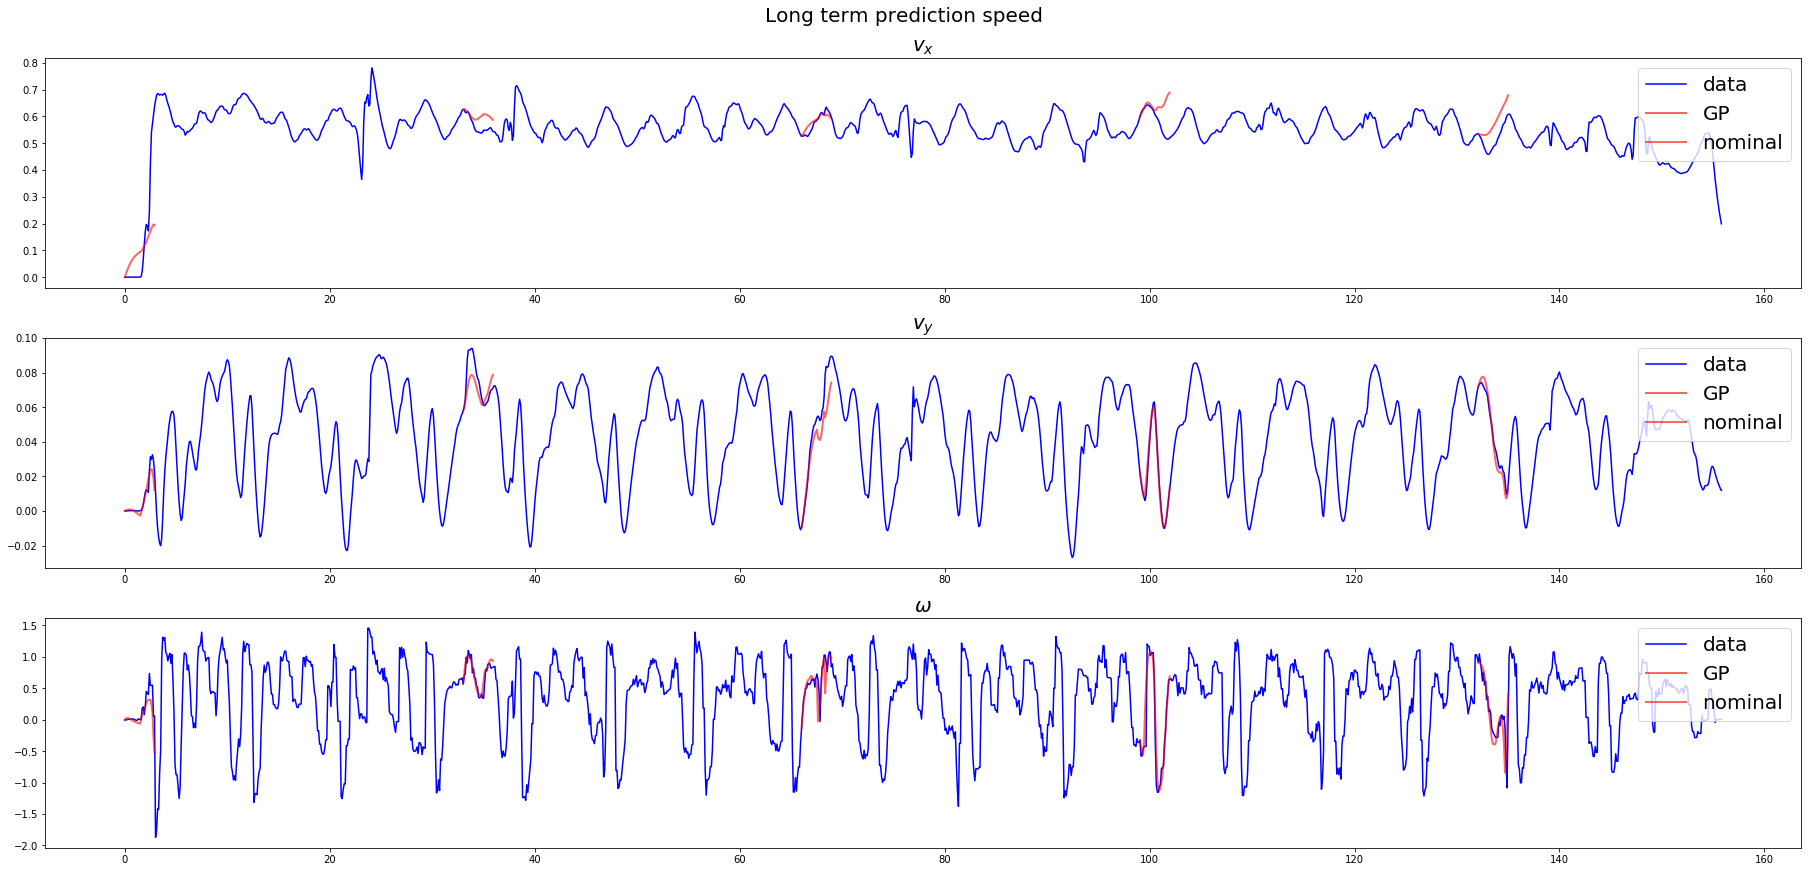

In [251]:
N = len(train_x)
t = np.linspace(0, N*time_step, N)

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(25, 12), constrained_layout=True)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Long term prediction speed',fontsize=20)

# ax1.set_title('Train $v_x$')
# ax1.plot(t, train_x[:,2], color='blue')

# ax3.set_title('Train $v_y$')
# ax3.plot(t, train_x[:,3], color='blue')

# ax5.set_title('Train $\omega$')
# ax5.plot(t, train_x[:,4], color='blue')


ax1.set_title('$v_x$',fontsize=20)
ax1.plot(t_test, test_x[:,2], color='blue')
# ax1.plot(t_test, vx_test[:-1], color='orchid', linewidth=2)
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_vx[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_vx[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$v_y$',fontsize=20)
ax2.plot(t_test, test_x[:,3], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_vy[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_vy[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\\omega$',fontsize=20)
ax3.plot(t_test, test_x[:,4], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_w[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_w[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('Multi_step_prediction_SPEED_with_MATRIX_mul.png',dpi=300)


In [252]:
xj = u_vx[1,:]
xj
outputscale_Delta_vx*np.exp((x0_pred[0]))

tensor(0.1584, dtype=torch.float64)

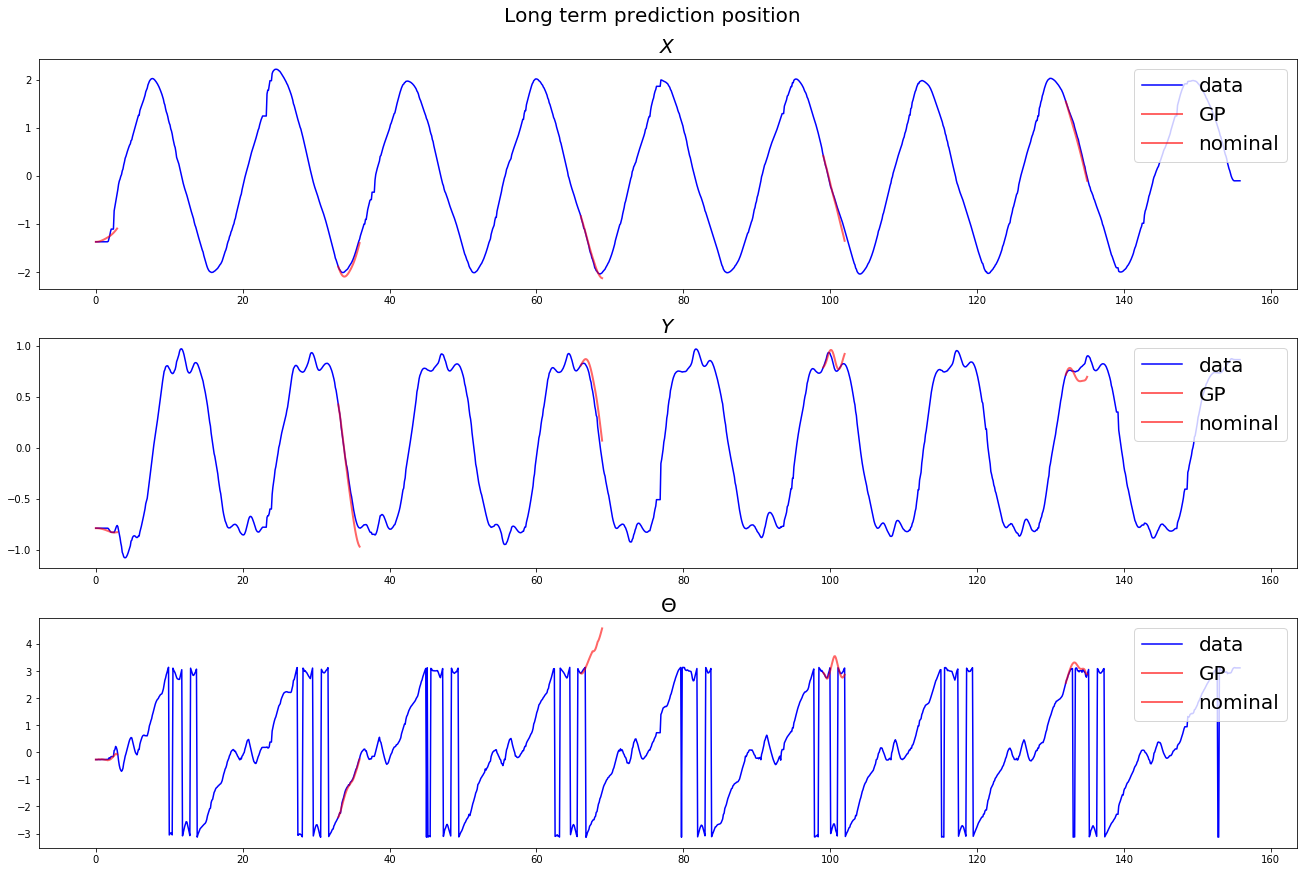

In [253]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(18, 12), constrained_layout=True)
fig.suptitle('Long term prediction position',fontsize=20)

ax1.set_title('$X$',fontsize=20)
ax1.plot(t_test, X_test[:-1], color='blue')
for i in range(preds):
    ax1.plot(times_to_plot[i,:], long_prediction_x[i,:], linewidth=2, color='red', alpha=0.6)
#     ax2.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], 2*np.sqrt(long_prediction_var_vx[i])+nominal_prediction_vx[i,:], alpha=0.5, color='orchid')
#     ax2.set_xlim((0, 120))
#     ax1.plot(times_to_plot[i,:], nominal_prediction_x[i,:], linewidth=2,color='green', alpha=0.6)
ax1.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax2.set_title('$Y$', fontsize=20)
ax2.plot(t_test, Y_test[:-1], color='blue')
for i in range(preds):
    ax2.plot(times_to_plot[i,:], long_prediction_y[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax4.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], 2*np.sqrt(long_prediction_var_vy[i])+nominal_prediction_vy[i,:], alpha=0.5, color='orchid')
#     ax4.set_xlim((0, 120))
#     ax2.plot(times_to_plot[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
ax2.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

ax3.set_title('$\Theta$', fontsize=20)
ax3.plot(t_test, theta_test[:-1], color='blue')
for i in range(preds):
    ax3.plot(times_to_plot[i,:], long_prediction_theta[i,:],  linewidth=2, color='red', alpha=0.6)
#     ax6.fill_between(times_to_plot[i,:], -2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], 2*np.sqrt(long_prediction_var_w[i])+nominal_prediction_w[i,:], alpha=0.5, color='orchid')
#     ax6.set_xlim((0, 120))
#     ax3.plot(times_to_plot[i,:], nominal_prediction_theta[i,:], linewidth=2,color='green', alpha=0.6)
ax3.legend(['data','GP','nominal'],fontsize=20, loc='upper right')

plt.savefig('Multi_step_prediction_POSITION_with_MATRIX_mul.png',dpi=300)

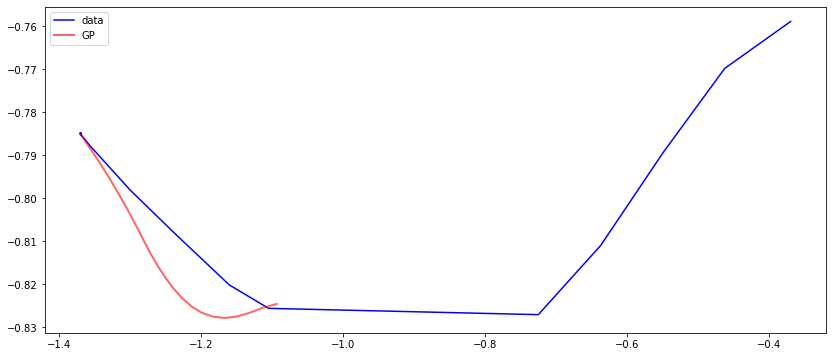

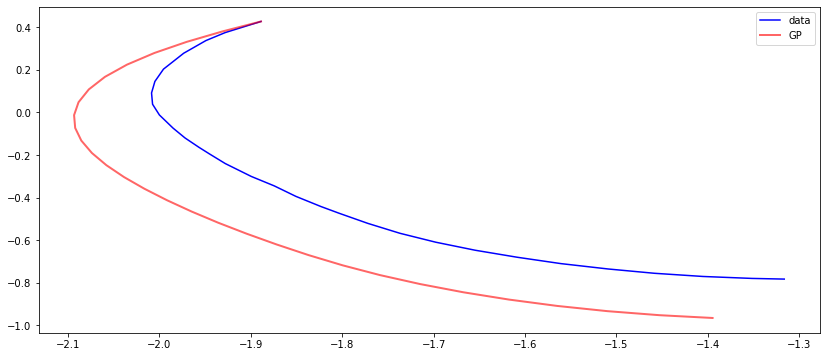

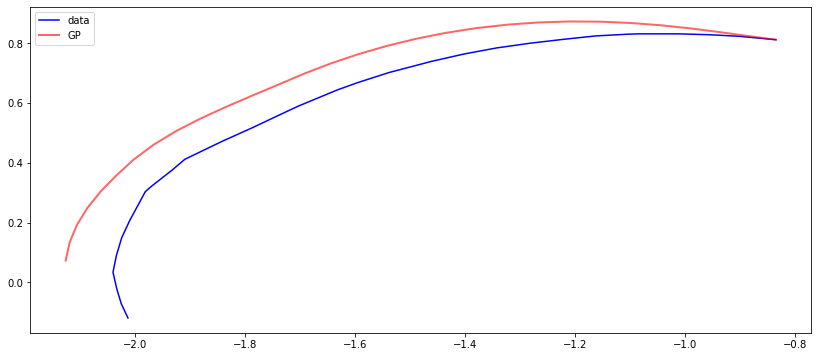

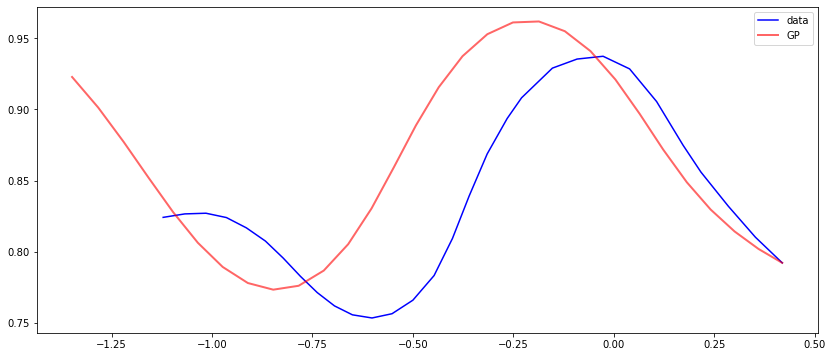

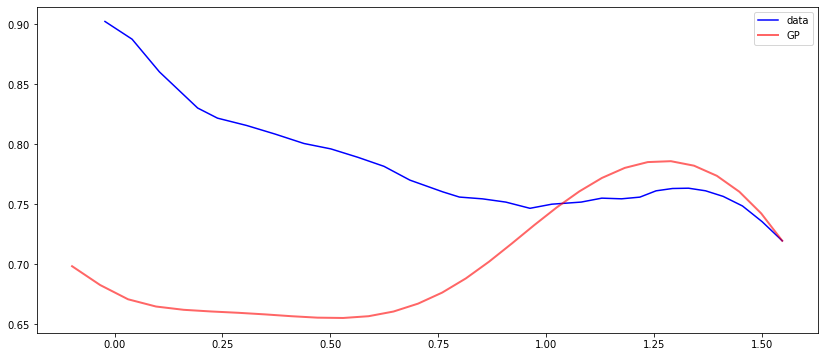

In [254]:
for i in range(preds):
    plt.figure(figsize=(14, 6))
    plt.plot(X_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)],Y_test[int(i*step*n_pred):int(i*step*n_pred+n_pred)], color='blue')
    plt.plot(long_prediction_x[i,:], long_prediction_y[i,:], linewidth=2, color='red', alpha=0.6)
#     plt.plot(nominal_prediction_x[i,:], nominal_prediction_y[i,:], linewidth=2,color='green', alpha=0.6)
    plt.legend(['data','GP','nominal'])

# Check throttle saturation

In [255]:
def ramp_tau(t, T):
    
    # t = time now
    # T = time span
    
    tau = 0.1 + (1-0.1)*t/T
    
    return tau

In [264]:
# steering is kept equal zero to properly isolate the effect of tau

T = 50
last_idx = int(T/time_step)
# x0 = np.array([ 0.1, 0, train_x[0,2:].cpu().detach().numpy() ])
a = np.array([ 0.1, 0])
# b = train_x[0,2:].cpu().detach().numpy()
b = np.array([ train_x[0,2].cpu().detach().numpy(), 0, 0 ])
x0 = np.hstack( (a, b) )
t = 0

vx = np.zeros(last_idx)
vy = np.zeros(last_idx)
w = np.zeros(last_idx)



for ii in range(last_idx):
    
    delta_vx = np.matmul( produce_K_xstar_X_Zero_mean_RBF(x0, u_vx, outputscale_Delta_vx, lengthscales_Delta_vx), right_vec_block_Delta_vx )
    delta_vy = np.matmul( produce_K_xstar_X_Zero_mean_RBF(x0, u_vy, outputscale_Delta_vy, lengthscales_Delta_vy), right_vec_block_Delta_vy )
    delta_w = np.matmul( produce_K_xstar_X_Zero_mean_RBF(x0, u_w, outputscale_Delta_w, lengthscales_Delta_w), right_vec_block_Delta_w )
    
#     vx[ii] = x0[2] + delta_vx
#     vy[ii] = x0[3] + delta_vy
#     w[ii] = x0[4] + delta_w

# The following is for GP predicting the entire quantities and not only the delta
    vx[ii] =  delta_vx
    vy[ii] = delta_vy
    w[ii] =  delta_w
    
    t = t + dt
    tau = ramp_tau(t,T)

    x0 = np.array([ tau, 0, vx[ii], vy[ii], w[ii] ])
#     x0 = np.array([ 1, 0, vx[ii], vy[ii], w[ii] ])
    

In [265]:
# x0

In [266]:
t_sim = np.linspace(0,T,last_idx)
t_sim.shape
tau_plot = ramp_tau(t_sim,T)

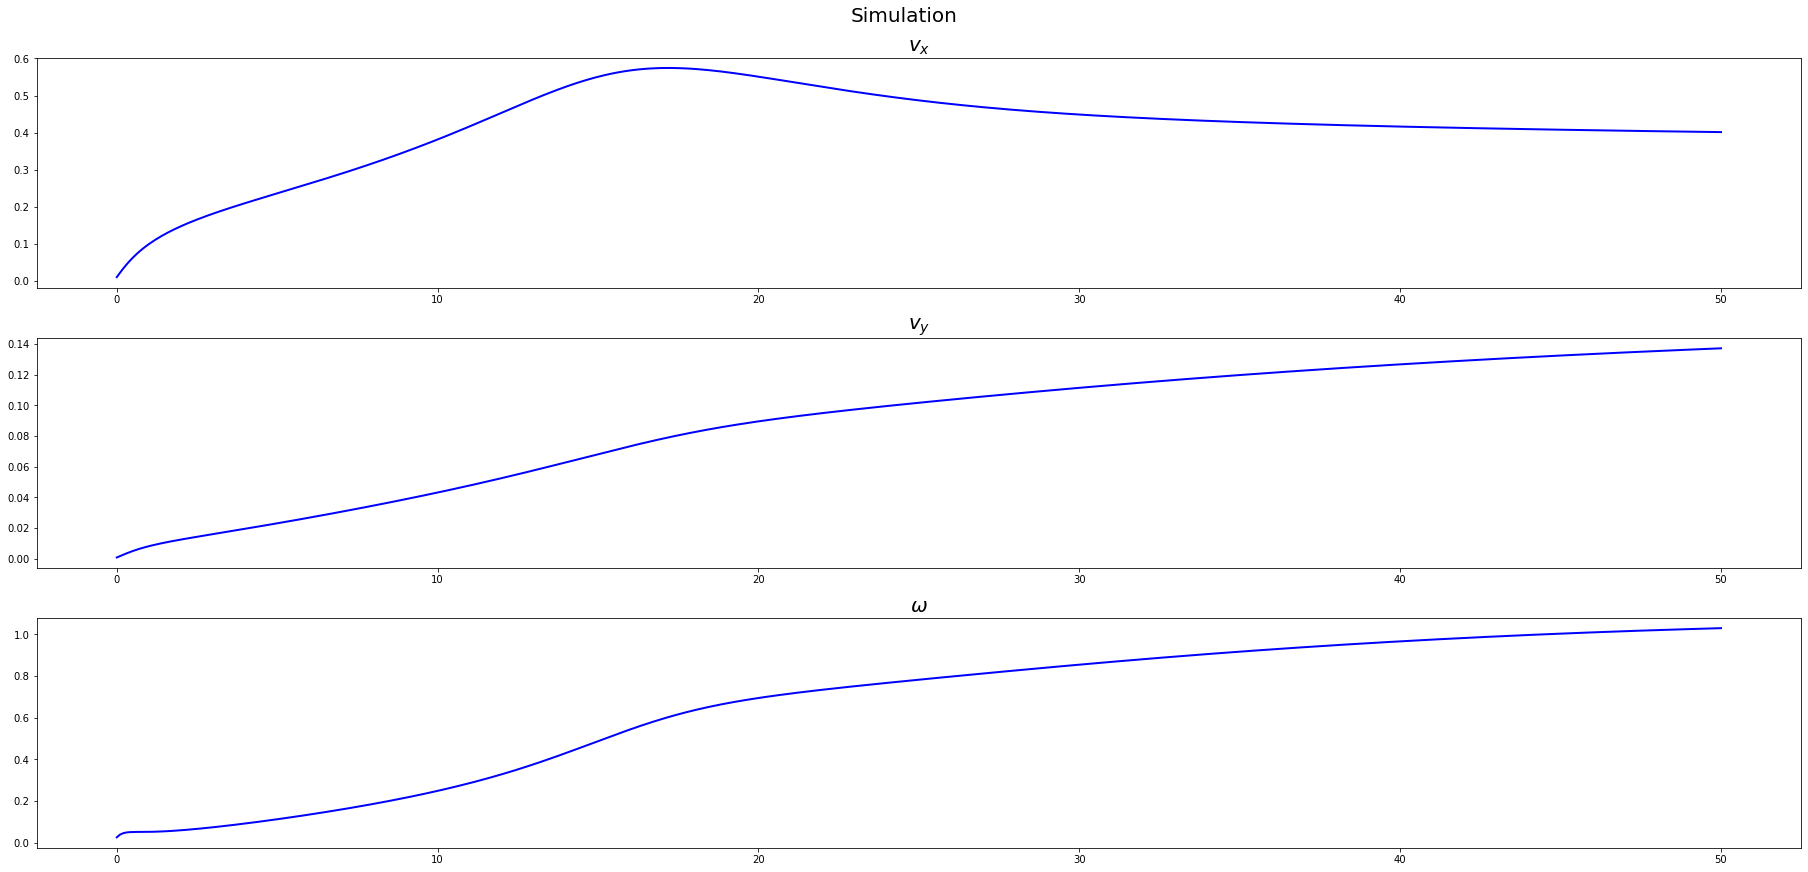

In [267]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 12), constrained_layout=True)
fig.suptitle('Simulation',fontsize=20)

ax1.set_title('$v_x$', fontsize=20)
ax1.plot(t_sim, vx, linewidth=2, color='blue')


ax2.set_title('$v_y$', fontsize=20)
ax2.plot(t_sim, vy, linewidth=2, color='blue')

ax3.set_title('$\\omega$', fontsize=20)
ax3.plot(t_sim, w, linewidth=2, color='blue')



Text(0, 0.5, 'v [m/s]')

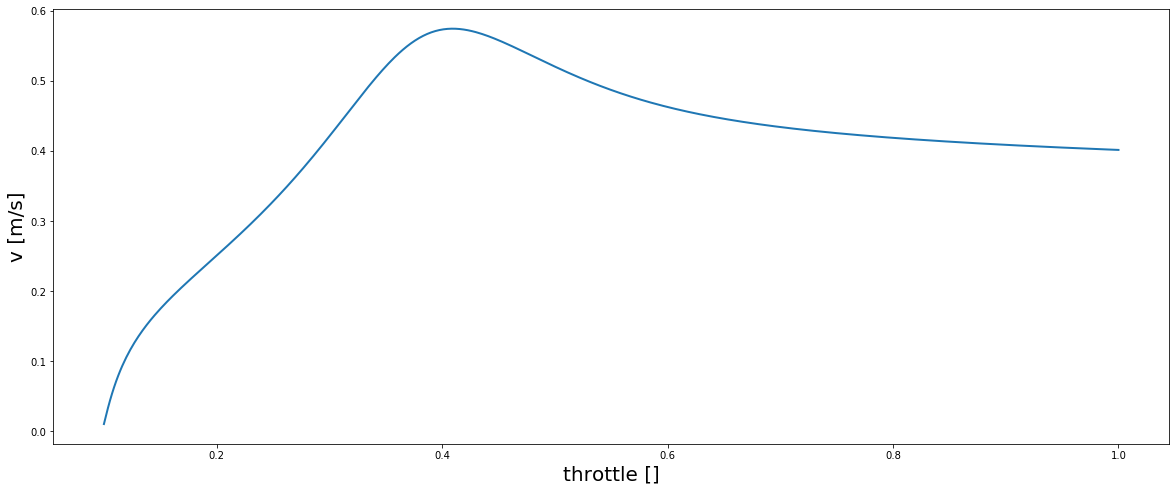

In [268]:
plt.figure(figsize=(20,8))
plt.plot(tau_plot, vx, linewidth=2)
plt.xlabel('throttle []', fontsize=20)
plt.ylabel('v [m/s]', fontsize=20)

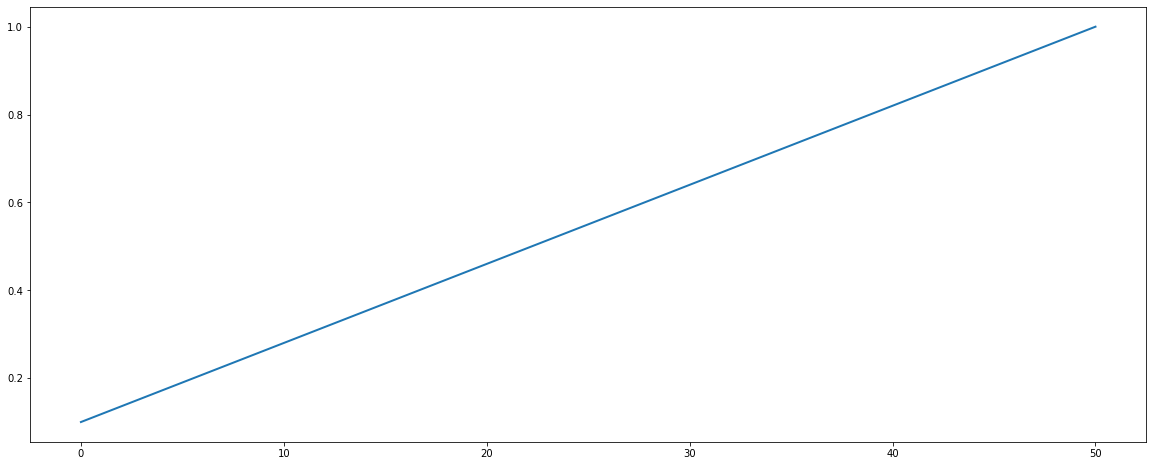

In [261]:
plt.figure(figsize=(20,8))
plt.plot(t_sim, tau_plot, linewidth=2)

In [262]:
outputscale_Delta_vx

tensor(0.1392)

In [263]:
u_vx

tensor([[ 5.4563e-01,  1.8151e-01,  9.0964e-02,  7.3828e-01, -1.5121e+00],
        [ 4.7823e-01,  1.0775e+00,  2.4731e-01,  1.0217e+00, -3.8706e-01],
        [ 1.7363e-01, -1.7091e-01,  5.2268e-01, -8.9649e-02, -5.2028e-02],
        [ 5.7947e-02,  1.9799e-01,  5.8488e-01,  5.0949e-02,  9.9645e-01],
        [ 3.9671e-01, -2.6980e-01, -8.0298e-01,  4.8211e-01,  7.2085e-01],
        [-4.7255e-01, -5.1584e-01,  5.5073e-01, -1.1786e+00,  1.5068e-03],
        [-2.2340e-01, -3.5507e-01,  4.1210e-01, -3.9847e-01, -1.5633e+00],
        [ 1.1486e-01, -8.4282e-01,  5.2971e-01,  1.6137e-01,  9.9940e-01],
        [ 1.8626e-01,  3.1196e-01,  5.7014e-01,  1.1135e-01,  5.4871e-01],
        [ 7.5320e-01, -1.3448e-01, -5.0924e-01,  8.6800e-01, -3.4234e-01],
        [ 8.1771e-01,  5.6202e-01,  8.4681e-02,  3.5882e-01,  1.0804e+00],
        [-1.0657e+00, -4.9475e-01, -9.7801e-02,  9.8674e-01, -8.4612e-01],
        [ 1.4801e-01,  8.3011e-01, -6.2947e-01,  9.7612e-01, -1.5891e+00],
        [-2.0983e+00, -7.